- ACC (adrenocortical carcinoma)
- UVM (uveal melanoma)
- SKCM (skin cutaneous melanoma)
- LGG (brain lower grade glioma)
- GBM (glioblatoma)


# Setup

In [ ]:
# Data manipulation and analysis
suppressPackageStartupMessages({
  library(dplyr)        # Data manipulation and transformation
  library(tidyverse)    # Collection of data science packages
  library(data.table)   # Fast data manipulation

  # Survival analysis
  library(survival)     # Core survival analysis functions
  library(survminer)    # Survival analysis visualization

  # Genomic data handling
  library(recount3)     # Access to RNA-seq data
  library(biomaRt)      # Access to genomic annotations
  library(TCGAbiolinks) # TCGA data access
  library(SummarizedExperiment) # Container for genomic data
  library(DESeq2)      # RNA-seq analysis
  library(GenomicFeatures) # Genomic feature handling
  library(rtracklayer)  # Import/export genomic tracks

  # Matrix operations
  library(matrixStats)  # Matrix calculations
  library(sparseMatrixStats) # Sparse matrix operations

  # Parallel processing
  library(parallel)     # Base R parallel processing
  library(BiocParallel) # Bioconductor parallel processing

  # Utilities
  library(httr)         # HTTP requests
  library(retry)        # Retry failed operations
  library(futile.logger) # Logging functionality
  library(viridis)      # Color palettes
})

In [5]:
# Set working directory
setwd("/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3/TCGA/Data_exploration")


In [ ]:
# Set R environment variables for better performance
Sys.setenv(R_MAX_NUM_DLLS = 150)
Sys.setenv(R_GC_MEM_GROW = 3)
Sys.setenv(R_ENABLE_JIT = 3)

# For parallel processing, you can set these based on your available cores
# For example, if you want to use 32 cores like in the shell script:
num_cores <- 4
Sys.setenv(OMP_NUM_THREADS = num_cores)
Sys.setenv(OPENBLAS_NUM_THREADS = num_cores)
Sys.setenv(MKL_NUM_THREADS = num_cores)

# Verify the environment variables were set
Sys.getenv(c("R_MAX_NUM_DLLS", "R_GC_MEM_GROW", "R_ENABLE_JIT", 
             "OMP_NUM_THREADS", "OPENBLAS_NUM_THREADS", "MKL_NUM_THREADS"))

BiocParallel::register(MulticoreParam(workers = num_cores))

# Analysis

In [ ]:
cancer_types <- c("ACC", "UVM", "SKCM", "LGG", "GBM")
cancer_type <- "LGG"
expression_threshold = 0.75
threshold = 0.75
grouping_method = "quartile"
gene_name = "SRRM3"

In [ ]:
projects <- available_projects()

In [ ]:
head(projects, 10)

In [110]:
print(unique(projects$file_source))
print(unique(projects$project_type))

[1] "sra"  "gtex" "tcga"
[1] "data_sources"


In [111]:
print(unique(projects[projects$file_source == "tcga",]$project))

 [1] "ACC"  "BLCA" "BRCA" "CESC" "CHOL" "COAD" "DLBC" "ESCA" "GBM"  "HNSC"
[11] "KICH" "KIRC" "KIRP" "LAML" "LGG"  "LIHC" "LUAD" "LUSC" "MESO" "OV"  
[21] "PAAD" "PCPG" "PRAD" "READ" "SARC" "SKCM" "STAD" "TGCT" "THCA" "THYM"
[31] "UCEC" "UCS"  "UVM" 


In [112]:
project_info <- subset(projects, 
                      project == toupper(cancer_type) &
                      file_source == "tcga" &
                      project_type == "data_sources")

In [113]:
project_info

,project,organism,file_source,project_home,project_type,n_samples
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
8724,LGG,human,tcga,data_sources/tcga,data_sources,532


In [114]:
clinical_dir <- file.path("../TCGA_clinical", 
                        sprintf("clinical.project-tcga-%s.2025-02-12", 
                                tolower(cancer_type)))
print(clinical_dir)

[1] "../TCGA_clinical/clinical.project-tcga-lgg.2025-02-12"


In [115]:
# Read clinical.tsv and follow_up.tsv files
clinical <- read.delim(file.path(clinical_dir, "clinical.tsv"), 
                    sep="\t", stringsAsFactors=FALSE, na.strings="'--")
follow_up <- read.delim(file.path(clinical_dir, "follow_up.tsv"), 
                        sep="\t", stringsAsFactors=FALSE, na.strings="'--")
exposure <- read.delim(file.path(clinical_dir, "exposure.tsv"), 
                        sep="\t", stringsAsFactors=FALSE, na.strings="'--")
family_history <- read.delim(file.path(clinical_dir, "family_history.tsv"), 
                        sep="\t", stringsAsFactors=FALSE, na.strings="'--")
pathology_details <- read.delim(file.path(clinical_dir, "pathology_detail.tsv"), 
                        sep="\t", stringsAsFactors=FALSE, na.strings="'--")


# Clinical data

In [116]:
head(clinical, 3)

cols_number <- ncol(clinical)
cat("Number of columns:", cols_number, "\n")

period = 7
# Print column names in groups
for (i in 0:floor((cols_number-1)/period)) {
  start_idx <- i*period + 1
  end_idx <- min((i+1)*period, cols_number)
  cat(paste(colnames(clinical)[start_idx:end_idx], collapse=", "), "\n")
}

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_birth,country_of_residence_at_enrollment,days_to_birth,⋯,treatment_dose_units,treatment_duration,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_outcome_duration,treatment_type
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<int>,⋯,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<lgl>,<chr>
1,001ad307-4ad3-4f1d-b2fc-efc032871c7e,TCGA-HT-A614,TCGA-LGG,47,false,NA,NA,NA,United States,-17392,⋯,NA,NA,NA,NA,NA,Adjuvant,unknown,NA,NA,"Pharmaceutical Therapy, NOS"
2,001ad307-4ad3-4f1d-b2fc-efc032871c7e,TCGA-HT-A614,TCGA-LGG,47,false,NA,NA,NA,United States,-17392,⋯,NA,NA,NA,NA,NA,NA,yes,NA,NA,Antiseizure Treatment
3,001ad307-4ad3-4f1d-b2fc-efc032871c7e,TCGA-HT-A614,TCGA-LGG,47,false,NA,NA,NA,United States,-17392,⋯,NA,NA,NA,NA,NA,NA,no,NA,NA,"Radiation Therapy, NOS"


Number of columns: 197 
case_id, case_submitter_id, project_id, age_at_index, age_is_obfuscated, cause_of_death, cause_of_death_source 
country_of_birth, country_of_residence_at_enrollment, days_to_birth, days_to_death, education_level, ethnicity, gender 
marital_status, occupation_duration_years, population_group, premature_at_birth, race, vital_status, weeks_gestation_at_birth 
year_of_birth, year_of_death, adrenal_hormone, age_at_diagnosis, ajcc_clinical_m, ajcc_clinical_n, ajcc_clinical_stage 
ajcc_clinical_t, ajcc_pathologic_m, ajcc_pathologic_n, ajcc_pathologic_stage, ajcc_pathologic_t, ajcc_serum_tumor_markers, ajcc_staging_system_edition 
ann_arbor_b_symptoms, ann_arbor_b_symptoms_described, ann_arbor_clinical_stage, ann_arbor_extranodal_involvement, ann_arbor_pathologic_stage, best_overall_response, burkitt_lymphoma_clinical_variant 
calgb_risk_group, cancer_detection_method, child_pugh_classification, clark_level, classification_of_tumor, cog_liver_stage, cog_neuroblastoma_ri

In [117]:
cat("vital_status:", unique(clinical$vital_status), "\n")
cat("cause_of_death:", unique(clinical$cause_of_death), "\n") 
cat("cause_of_death_source:", unique(clinical$cause_of_death_source), "\n")
cat("gender:", unique(clinical$gender), "\n")
cat("population_group:", unique(clinical$population_group), "\n")
cat("race:", unique(clinical$race), "\n")
cat("age_at_diagnosis:", unique(clinical$age_at_diagnosis), "\n")
cat("classification_of_tumor:", unique(clinical$classification_of_tumor), "\n")
cat("metastasis_at_diagnosis:", unique(clinical$metastasis_at_diagnosis), "\n")
cat("tumor_burden:", unique(clinical$tumor_burden), "\n")
cat("tumor_depth:", unique(clinical$tumor_depth), "\n")
cat("tumor_grade:", unique(clinical$tumor_grade), "\n")
cat("tumor_grade_category:", unique(clinical$tumor_grade_category), "\n")

vital_status: Alive Dead Not Reported 
cause_of_death: NA Not Reported 
cause_of_death_source: NA 
gender: male female not reported 
population_group: NA 
race: white black or african american asian not reported Unknown american indian or alaska native 
age_at_diagnosis: 17392 13934 11332 16334 19610 6987 6480 16945 17471 18443 17874 18341 14814 11854 11118 11252 19056 16102 15178 18321 8820 16136 16117 13108 21811 22241 12851 11070 15513 17289 15658 20558 13198 7380 20609 13680 26904 10812 13314 21979 22866 14659 14939 12845 11684 NA 12728 11906 11357 15435 15051 16163 23680 8642 21964 14936 15629 16084 23482 8752 10849 19903 25357 25266 21133 11533 11427 19310 19207 22342 10150 16470 19950 24122 5267 24282 9345 12393 14279 17390 11741 22997 22811 26992 22847 22038 19432 15091 11083 7716 11528 11935 12960 12248 12595 13443 13217 13345 13387 13525 21990 16843 18410 17878 16297 17481 10053 9643 9710 10378 10494 10434 9546 22585 18799 14171 9614 13453 16415 14405 14205 18955 13943 12820 

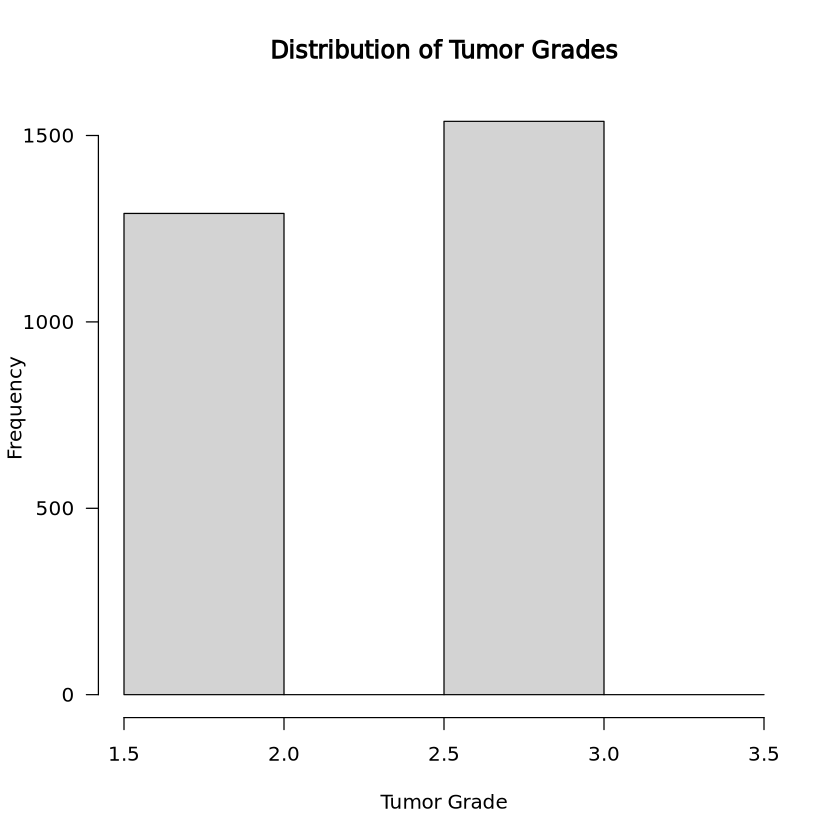

In [118]:
#### tumor_grade ################################################################
# First remove NAs and convert valid grades to numeric
tumor_grades <- clinical$tumor_grade
tumor_grades <- tumor_grades[!is.na(tumor_grades) & tumor_grades != ""]

# Extract numeric grade from G2/G3 format
tumor_grades_num <- as.numeric(gsub("G", "", tumor_grades))

# Create histogram
hist(tumor_grades_num,
     main="Distribution of Tumor Grades", 
     xlab="Tumor Grade",
     ylab="Frequency",
     breaks=seq(1.5, 3.5, by=0.5),
     yaxt="n")

# Add y-axis
axis(2, las=1) # Add y-axis with horizontal labels

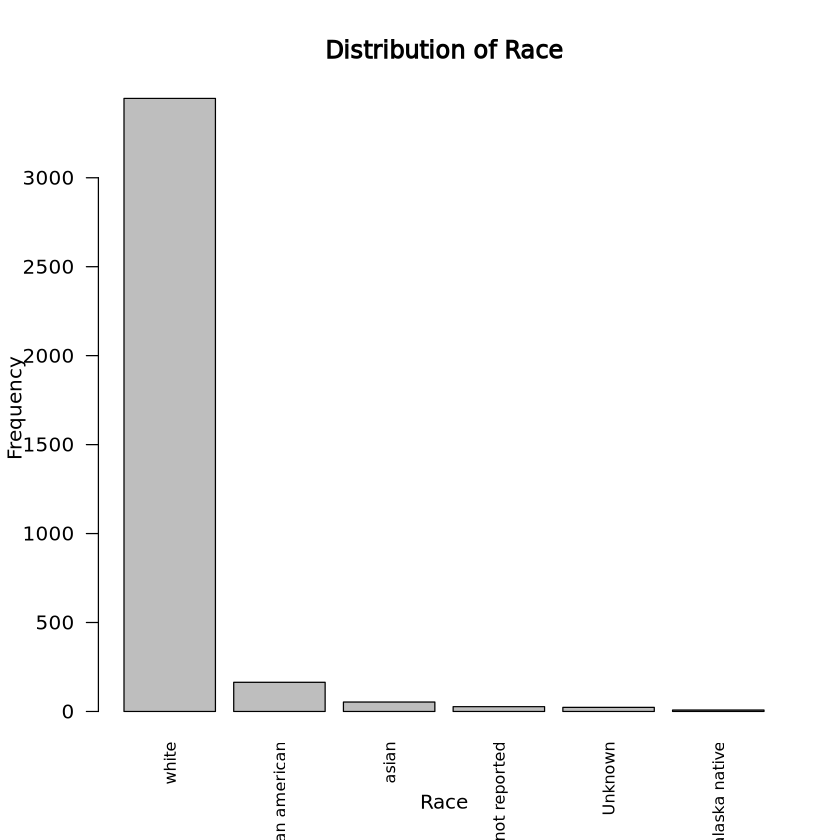

In [119]:
#### race #######################################################################
# Get race data and remove NAs and empty strings
race <- clinical$race
race <- race[!is.na(race) & race != ""]

# Convert to factor with proper categories
race <- factor(race, 
              levels=c("white", 
                      "black or african american", 
                      "asian",
                      "not reported",
                      "Unknown",
                      "american indian or alaska native"))

# Create bar plot instead of histogram since race is categorical
barplot(table(race),
        main="Distribution of Race",
        xlab="Race",
        ylab="Frequency",
        las=2, # Rotate x-axis labels
        cex.names=0.8) # Reduce label text size

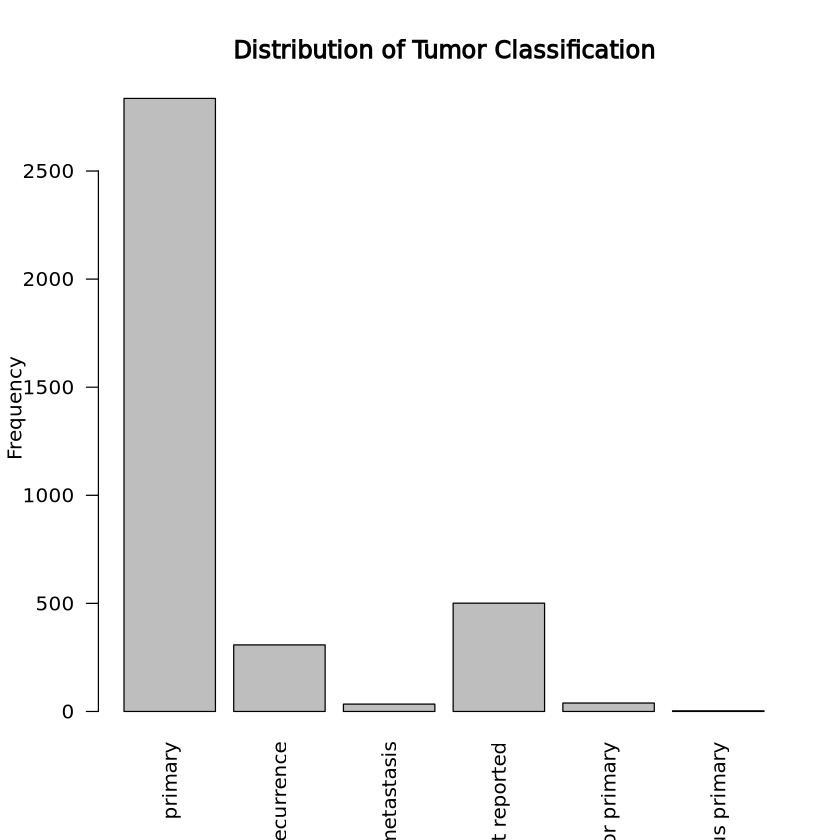

In [120]:
#### classification_of_tumor #####################################################
# Get tumor classification data and remove NAs and empty strings
tumor_class <- clinical$classification_of_tumor
tumor_class <- tumor_class[!is.na(tumor_class) & tumor_class != ""]

# Convert to factor with proper categories
tumor_class <- factor(tumor_class,
                     levels=c("primary",
                             "recurrence",
                             "metastasis", 
                             "not reported",
                             "Prior primary",
                             "Synchronous primary"))

# Create bar plot since tumor classification is categorical
barplot(table(tumor_class),
        main="Distribution of Tumor Classification",
        xlab="",
        ylab="Frequency", 
        las=2)


# Follow up

In [121]:
head(follow_up, 3)

cols_number <- ncol(follow_up)
cat("Number of columns:", cols_number, "\n")

period = 10
# Print column names in groups
for (i in 0:floor((cols_number-1)/period)) {
  start_idx <- i*period + 1
  end_idx <- min((i+1)*period, cols_number)
  cat(paste(colnames(follow_up)[start_idx:end_idx], collapse=", "), "\n")
}

,case_id,case_submitter_id,project_id,adverse_event,adverse_event_grade,aids_risk_factors,barretts_esophagus_goblet_cells_present,bmi,body_surface_area,cause_of_response,⋯,test_analyte_type,test_result,test_units,test_value,test_value_range,timepoint_category.1,transcript,variant_origin,variant_type,zygosity
,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<chr>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<chr>,<lgl>
1,001ad307-4ad3-4f1d-b2fc-efc032871c7e,TCGA-HT-A614,TCGA-LGG,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,Not Reported,NA,NA,NA,NA
2,001ad307-4ad3-4f1d-b2fc-efc032871c7e,TCGA-HT-A614,TCGA-LGG,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,Last Contact,NA,NA,NA,NA
3,001ad307-4ad3-4f1d-b2fc-efc032871c7e,TCGA-HT-A614,TCGA-LGG,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,Follow-up,NA,NA,NA,NA


Number of columns: 139 
case_id, case_submitter_id, project_id, adverse_event, adverse_event_grade, aids_risk_factors, barretts_esophagus_goblet_cells_present, bmi, body_surface_area, cause_of_response 
cd4_count, cdc_hiv_risk_factors, comorbidities, comorbidity, comorbidity_method_of_diagnosis, days_to_adverse_event, days_to_comorbidity, days_to_first_event, days_to_follow_up, days_to_imaging 
days_to_progression, days_to_progression_free, days_to_recurrence, days_to_risk_factor, diabetes_treatment_type, discontiguous_lesion_count, disease_response, dlco_ref_predictive_percent, ecog_performance_status, evidence_of_progression_type 
evidence_of_recurrence_type, eye_color, fev1_fvc_post_bronch_percent, fev1_fvc_pre_bronch_percent, fev1_ref_post_bronch_percent, fev1_ref_pre_bronch_percent, first_event, follow_up_id, follow_up_submitter_id, haart_treatment_indicator 
height, hepatitis_sustained_virological_response, histologic_progression, history_of_tumor, history_of_tumor_type, hiv_vira

In [122]:
cat("adverse_event:", unique(follow_up$adverse_event), "\n")
cat("adverse_event_grade:", unique(follow_up$adverse_event_grade), "\n") 
cat("disease_response:", unique(follow_up$disease_response), "\n")
cat("histologic_progression:", unique(follow_up$histologic_progression), "\n")

adverse_event: NA 
adverse_event_grade: NA 
disease_response: NA WT-With Tumor TF-Tumor Free Unknown 
histologic_progression: NA 


# Pathology details

In [123]:
head(pathology_details, 3)

cols_number <- ncol(pathology_details)
cat("Number of columns:", cols_number, "\n")

period = 10
# Print column names in groups
for (i in 0:floor((cols_number-1)/period)) {
  start_idx <- i*period + 1
  end_idx <- min((i+1)*period, cols_number)
  cat(paste(colnames(pathology_details)[start_idx:end_idx], collapse=", "), "\n")
}

,case_id,case_submitter_id,project_id,diagnosis_id,diagnosis_submitter_id,additional_pathology_findings,anaplasia_present,anaplasia_present_type,bone_marrow_malignant_cells,breslow_thickness,⋯,tumor_infiltrating_macrophages,tumor_largest_dimension_diameter,tumor_length_measurement,tumor_level_prostate,tumor_shape,tumor_thickness,tumor_width_measurement,vascular_invasion_present,vascular_invasion_type,zone_of_origin_prostate
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,001ad307-4ad3-4f1d-b2fc-efc032871c7e,TCGA-HT-A614,TCGA-LGG,1c63a839-547e-59c4-abd5-c7c1c0960656,TCGA-HT-A614_diagnosis,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,0061e9ef-df6a-414e-af64-c88f8192e2d3,TCGA-E1-5311,TCGA-LGG,52ea209b-6f5e-51f8-9713-3102640183fa,TCGA-E1-5311_diagnosis,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,0073a136-d5f4-4fd6-88f9-711768f2abc6,TCGA-VM-A8CF,TCGA-LGG,679e9de4-708c-5a80-a0f0-e3338b49867e,TCGA-VM-A8CF_diagnosis,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Number of columns: 86 
case_id, case_submitter_id, project_id, diagnosis_id, diagnosis_submitter_id, additional_pathology_findings, anaplasia_present, anaplasia_present_type, bone_marrow_malignant_cells, breslow_thickness 
circumferential_resection_margin, columnar_mucosa_present, consistent_pathology_review, days_to_pathology_detail, dysplasia_degree, dysplasia_type, epithelioid_cell_percent, epithelioid_cell_percent_range, extracapsular_extension, extracapsular_extension_present 
extranodal_extension, extraocular_nodule_size, extrascleral_extension, extrascleral_extension_present, extrathyroid_extension, greatest_tumor_dimension, gross_tumor_weight, histologic_progression_type, intratubular_germ_cell_neoplasia_present, largest_extrapelvic_peritoneal_focus 
lymph_node_dissection_method, lymph_node_dissection_site, lymph_node_involved_site, lymph_node_involvement, lymph_nodes_positive, lymph_nodes_removed, lymph_nodes_tested, lymphatic_invasion_present, margin_status, measurement_type 

In [124]:
cat("greatest_tumor_dimension:", unique(pathology_details$greatest_tumor_dimension), "\n")
cat("tumor_width_measurement:", unique(pathology_details$tumor_width_measurement), "\n") 
cat("tumor_largest_dimension_diameter:", unique(pathology_details$tumor_largest_dimension_diameter), "\n")
cat("anaplasia_present:", unique(pathology_details$anaplasia_present), "\n")

greatest_tumor_dimension: NA 
tumor_width_measurement: NA 
tumor_largest_dimension_diameter: NA 
anaplasia_present: NA 
